# Udacity Data Scientist Nanodegree

## Project: Writing a Data Scientist Blog Post

### Analyising that Airbnb data

### 1. Business Understanding
In this notebook, I will focus on answering three business questions using descriptive analysis, inferential statistics, and machine learning:
1. Which areas get the best rental rates? Help new host understand if thier property is in a wanted aread 
2. Which properties get the best rental rates? This will help new host understand the best selling point of thier property 
3. How well can we predict the listing price?  Estimating how much thier propery is worth and how much they could make
4. 


### 2. Data Understanding
2.1 Load the data

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [5]:
# load boston calendar data
boston_calendar = pd.read_csv('data/calendar_boston.csv', delimiter = ',')
boston_calendar['city'] = 'Boston'
boston_calendar.head()




,listing_id,date,available,price,city
0,12147973,2017-09-05,f,NaN,Boston
1,12147973,2017-09-04,f,NaN,Boston
2,12147973,2017-09-03,f,NaN,Boston
3,12147973,2017-09-02,f,NaN,Boston
4,12147973,2017-09-01,f,NaN,Boston


In [48]:
# load boston listing data
boston_list = pd.read_csv('data/listings_boston.csv', delimiter = ',')
boston_list['city'] = 'Boston'
boston_list.drop(labels = ['access', 'interaction', 'house_rules'], axis = 1, inplace = True)
boston_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [49]:
boston_list.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

In [50]:
list(boston_list.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',


In [21]:
# load seattle calendar data
seattle_calendar = pd.read_csv('data/calendar_seattle.csv', delimiter = ',')
seattle_calendar['city'] = 'Seattle'
seattle_calendar.head()

,listing_id,date,available,price,city
0,241032,2016-01-04,t,$85.00,Seattle
1,241032,2016-01-05,t,$85.00,Seattle
2,241032,2016-01-06,f,NaN,Seattle
3,241032,2016-01-07,f,NaN,Seattle
4,241032,2016-01-08,f,NaN,Seattle


In [24]:
# load seattle listing data
seattle_list = pd.read_csv('data/listings_seattle.csv', delimiter = ',')
seattle_list['city'] = 'Seattle'
seattle_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [144]:
# merge together
calendar_all = pd.concat([boston_calendar, seattle_calendar])
calendar_all.date = pd.to_datetime(calendar_all.date)
calendar_all['weekday'] = calendar_all['date'].dt.dayofweek
calendar_all['price']= calendar_all.price.str.replace('$','')
calendar_all['price']= calendar_all.price.str.replace(',','')
calendar_all['price']= calendar_all['price'].fillna(0)
calendar_all['price'] = calendar_all['price'].astype(float)

listings_all = pd.concat([boston_list, seattle_list])

In [148]:
#check shape and strcuture
shape_cal = calendar_all.shape
shape_lis = listings_all.shape

print('The shape of the combine calendar and listing is: {} row and cloumns for the calendar and {} row and cloumns for the listing'.format(shape_cal, shape_lis))
listings_all.head()

The shape of the combine calendar and listing is: (2702460, 6) row and cloumns for the calendar and (7403, 92) row and cloumns for the listing


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [146]:
calendar_all.head()

,listing_id,date,available,price,city,weekday
0,12147973,2017-09-05,f,0.0,Boston,1
1,12147973,2017-09-04,f,0.0,Boston,0
2,12147973,2017-09-03,f,0.0,Boston,6
3,12147973,2017-09-02,f,0.0,Boston,5
4,12147973,2017-09-01,f,0.0,Boston,4


2.2 Check the data range
Once data is loaded and merged, I will now look at how much missing data and data ranges

In [149]:
listings_all.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,7.403000e+03,7.403000e+03,7.403000e+03,7401.000000,7401.000000,7403.000000,7403.000000,7403.000000,7373.000000,7387.000000,...,5943.000000,5922.000000,5932.000000,5925.000000,5934.000000,5926.000000,5926.000000,0.0,7403.000000,6020.000000
mean,6.950001e+06,2.016049e+13,2.021053e+07,32.222537,32.222537,45.067727,-97.515448,3.200189,1.241150,1.282659,...,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,NaN,7.686073,2.028161
std,4.052397e+06,4.009296e+08,1.962309e+07,123.585161,123.585161,2.643568,25.613198,1.890166,0.549408,0.823251,...,8.207451,0.821783,0.999271,0.682247,0.656589,0.775312,0.892824,NaN,21.465871,1.968696
min,3.335000e+03,2.016010e+13,4.193000e+03,0.000000,0.000000,42.235942,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.010000
25%,3.864100e+06,2.016010e+13,4.343164e+06,1.000000,1.000000,42.345668,-122.330837,2.000000,1.000000,1.000000,...,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.590000
50%,7.035240e+06,2.016010e+13,1.448650e+07,1.000000,1.000000,47.542907,-122.276419,2.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,1.370000
75%,9.500804e+06,2.016091e+13,3.028359e+07,4.000000,4.000000,47.624460,-71.079518,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,3.000000,2.890000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,47.733358,-71.000100,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,136.000000,19.150000


2.3 Determine what is noise and remove
Let start with removing information not required to answer my questions:
1. the urls linked to the images
2. text descriptions
3. names such as host_name

In [156]:
# list of columns/feature to keep
cols = ['id', 'host_id', 'host_since', 'last_scraped', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 
        'host_is_superhost','host_identity_verified', 'neighbourhood_cleansed', 'city', 'neighbourhood_group_cleansed',
        'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms','bedrooms', 'beds','bed_type',
        'amenities', 'square_feet', 'price', 'weekly_price','monthly_price', 'security_deposit', 'cleaning_fee', 
        'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_365',
        'number_of_reviews','first_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'requires_license', 'license', 
        'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 
        'calculated_host_listings_count', 'reviews_per_month']
listing_rm = listings_all[cols]

listing_rm.head()

,id,host_id,host_since,last_scraped,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,...,review_scores_communication,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,31303940,2015-04-15,2016-09-07,NaN,NaN,NaN,f,f,Roslindale,...,NaN,NaN,f,NaN,f,moderate,f,f,1,NaN
1,3075044,2572247,2012-06-07,2016-09-07,within an hour,100%,100%,f,t,Roslindale,...,10.0,9.0,f,NaN,t,moderate,f,f,1,1.30
2,6976,16701,2009-05-11,2016-09-07,within a few hours,100%,88%,t,t,Roslindale,...,10.0,10.0,f,NaN,f,moderate,t,f,1,0.47
3,1436513,6031442,2013-04-21,2016-09-07,within a few hours,100%,50%,f,f,Roslindale,...,10.0,10.0,f,NaN,f,moderate,f,f,1,1.00
4,7651065,15396970,2014-05-11,2016-09-07,within an hour,100%,100%,t,t,Roslindale,...,10.0,10.0,f,NaN,f,flexible,f,f,1,2.25


### 3. Data Preparation

3.1 Reviewing data missing from columns

license                         1.000000
square_feet                     0.979333
monthly_price                   0.675132
weekly_price                    0.608132
security_deposit                0.566662
has_availability                0.484263
neighbourhood_group_cleansed    0.484263
cleaning_fee                    0.288667
review_scores_accuracy          0.200054
review_scores_checkin           0.199649
dtype: float64

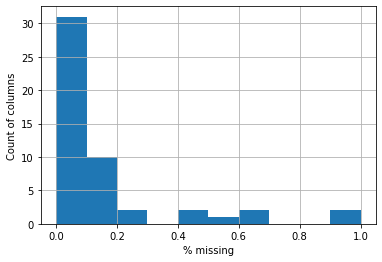

In [161]:
nan_cols = listing_rm.isnull().mean().sort_values(ascending = False)
graph = nan_cols.hist()  
graph.set_xlabel("% missing")
graph.set_ylabel("Count of columns")
nan_cols.head(n=10)